In [18]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [20]:
!unzip /content/drive/MyDrive/dataset3.zip -d /content/dataset

Archive:  /content/drive/MyDrive/dataset3.zip
replace /content/dataset/__MACOSX/._processed_others_5.parquet? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [21]:
!apt-get update # Update apt-get repository.
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # Install Java.
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz # Download Apache Sparks.
!tar xf spark-3.1.1-bin-hadoop3.2.tgz # Unzip the tgz file.
!pip install -q findspark # Install findspark. Adds PySpark to the System path during runtime.

# Set environment variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

# Initialize findspark
import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done


In [22]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace, length, dayofweek, when
from pyspark.sql.types import FloatType
from pyspark.sql.functions import udf
from pyspark.ml.feature import Bucketizer
import matplotlib.pyplot as plt
from pyspark.sql import functions as F
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, length, dayofweek, when, to_timestamp
from pyspark.ml.feature import Bucketizer, VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns


spark = SparkSession.builder \
    .appName("LogisticRegressionExample") \
    .getOrCreate()


df = spark.read.parquet("dataset/processed_others_5.parquet")

df.printSchema()
df.show(5)

root
 |-- class: double (nullable = true)
 |-- features: vector (nullable = true)

+-----+--------------------+
|class|            features|
+-----+--------------------+
|  0.0|[50.0,321.0,0.0,9...|
|  0.0|[0.0,102.0,1.0,4....|
|  0.0|(8,[1,3,4,7],[102...|
|  0.0|(8,[1,3,4,7],[125...|
|  0.0|[66.6666641235351...|
+-----+--------------------+
only showing top 5 rows



In [23]:
class_distribution = df.groupBy("class").count().orderBy("class")
class_distribution.show()



train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)


+-----+-----+
|class|count|
+-----+-----+
|  0.0|58343|
|  1.0|57990|
+-----+-----+



Logistic Regression Test Accuracy = 0.72
Class 0.0:
  Precision = 0.74
  Recall = 0.66
  F1 Score = 0.70
Class 1.0:
  Precision = 0.70
  Recall = 0.77
  F1 Score = 0.73


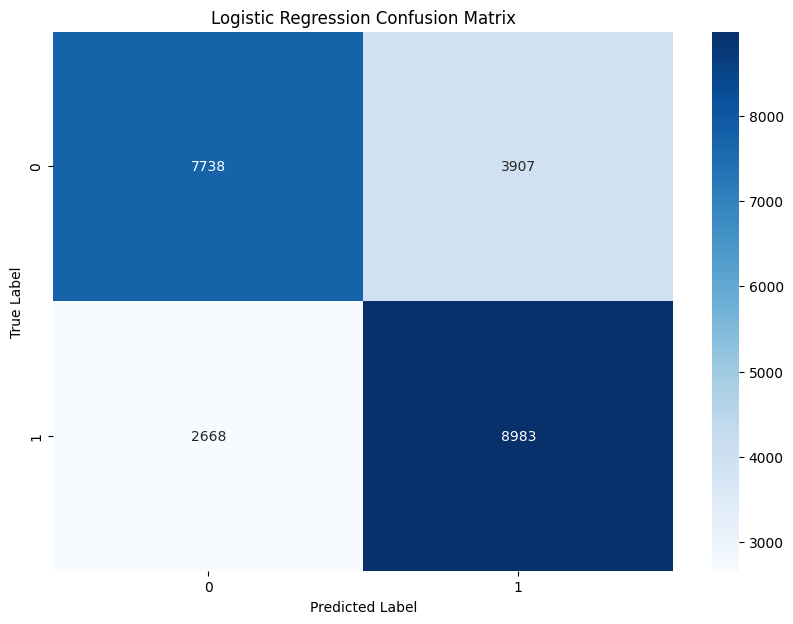

LR Test RMSE = 0.53
Logistic Regression Test AUC = 0.81


In [24]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the logistic regression model
model = LogisticRegression(labelCol="class", featuresCol="features")

# Define the pipeline
pipeline = Pipeline(stages=[model])

# Train the model using the training data
trained_model = pipeline.fit(train_df)

# Make predictions on the testing data
predictions = trained_model.transform(test_df)

# Calculate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Logistic Regression Test Accuracy = {accuracy:.2f}")

# Calculate other metrics
predictionAndLabels = predictions.select("prediction", "class").rdd.map(lambda row: (row[0], row[1]))
metrics = MulticlassMetrics(predictionAndLabels)

labels = predictions.select("class").distinct().collect()
labels = [row['class'] for row in labels]

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1Score = metrics.fMeasure(label)
    print(f"Class {label}:")
    print(f"  Precision = {precision:.2f}")
    print(f"  Recall = {recall:.2f}")
    print(f"  F1 Score = {f1Score:.2f}")

# Create confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray().astype(int)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Logistic Regression Confusion Matrix')
plt.show()

# Calculate RMSE
regression_evaluator = RegressionEvaluator(labelCol="class", predictionCol="prediction", metricName="rmse")
rmse = regression_evaluator.evaluate(predictions)
print(f"LR Test RMSE = {rmse:.2f}")

# Calculate AUC
binary_evaluator = BinaryClassificationEvaluator(labelCol="class", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = binary_evaluator.evaluate(predictions)
print(f"Logistic Regression Test AUC = {auc:.2f}")

SVM Test Accuracy = 0.72
Class 0.0:
  Precision = 0.77
  Recall = 0.62
  F1 Score = 0.69
Class 1.0:
  Precision = 0.68
  Recall = 0.81
  F1 Score = 0.74


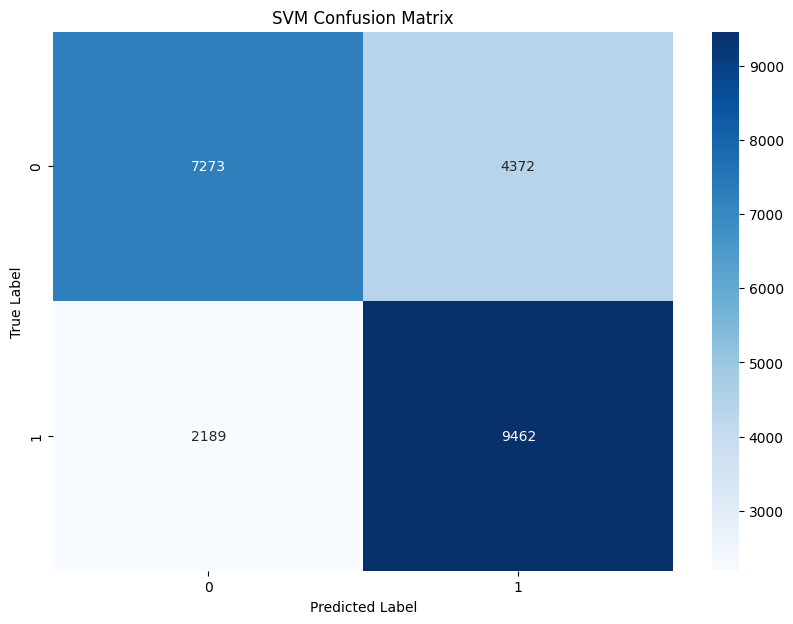

LR Test RMSE = 0.53
Logistic Regression Test AUC = 0.81


In [26]:
from pyspark.ml.classification import LinearSVC
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, RegressionEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns

# Define the SVM model
svm = LinearSVC(labelCol="class", featuresCol="features")

# Define the pipeline
pipeline = Pipeline(stages=[svm])

# Train the model using the training data
trained_model = pipeline.fit(train_df)

# Make predictions on the testing data
predictions = trained_model.transform(test_df)

# Calculate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"SVM Test Accuracy = {accuracy:.2f}")

# Calculate other metrics
predictionAndLabels = predictions.select("prediction", "class").rdd.map(lambda row: (row[0], row[1]))
metrics = MulticlassMetrics(predictionAndLabels)

labels = predictions.select("class").distinct().collect()
labels = [row['class'] for row in labels]

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1Score = metrics.fMeasure(label)
    print(f"Class {label}:")
    print(f"  Precision = {precision:.2f}")
    print(f"  Recall = {recall:.2f}")
    print(f"  F1 Score = {f1Score:.2f}")

# Create confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix = confusion_matrix.astype(int)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Confusion Matrix')
plt.show()

# Calculate RMSE (if applicable for your context)
# Convert classes to numeric if they are not already
predictions = predictions.withColumn("class", predictions["class"].cast("double"))

# Calculate RMSE
regression_evaluator = RegressionEvaluator(labelCol="class", predictionCol="prediction", metricName="rmse")
rmse = regression_evaluator.evaluate(predictions)
print(f"LR Test RMSE = {rmse:.2f}")

# Calculate AUC
binary_evaluator = BinaryClassificationEvaluator(labelCol="class", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = binary_evaluator.evaluate(predictions)
print(f"Logistic Regression Test AUC = {auc:.2f}")

Decision Tree Test Accuracy = 0.73
Class 0.0:
  Precision = 0.72
  Recall = 0.75
  F1 Score = 0.73
Class 1.0:
  Precision = 0.74
  Recall = 0.71
  F1 Score = 0.72


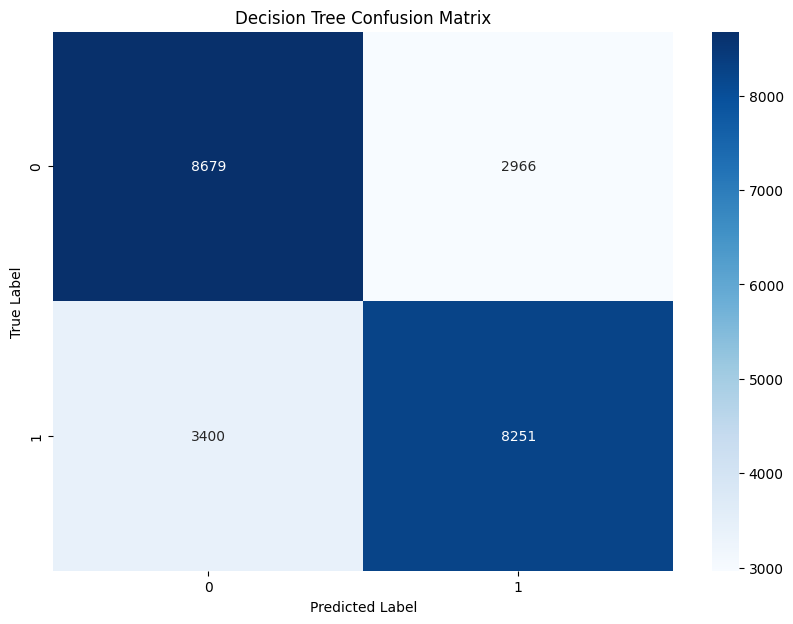

LR Test RMSE = 0.52
Logistic Regression Test AUC = 0.70


In [27]:
from pyspark.ml.classification import DecisionTreeClassifier


# Define the Decision Tree model
dt = DecisionTreeClassifier(labelCol="class", featuresCol="features")

# Define the pipeline
pipeline = Pipeline(stages=[dt])

# Train the model using the training data
trained_model = pipeline.fit(train_df)

# Make predictions on the testing data
predictions = trained_model.transform(test_df)

# Calculate accuracy
evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Decision Tree Test Accuracy = {accuracy:.2f}")

# Calculate other metrics
predictionAndLabels = predictions.select("prediction", "class").rdd.map(lambda row: (row[0], row[1]))
metrics = MulticlassMetrics(predictionAndLabels)

labels = predictions.select("class").distinct().collect()
labels = [row['class'] for row in labels]

for label in labels:
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1Score = metrics.fMeasure(label)
    print(f"Class {label}:")
    print(f"  Precision = {precision:.2f}")
    print(f"  Recall = {recall:.2f}")
    print(f"  F1 Score = {f1Score:.2f}")

# Create confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()
confusion_matrix = confusion_matrix.astype(int)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Decision Tree Confusion Matrix')
plt.show()


# Calculate RMSE
regression_evaluator = RegressionEvaluator(labelCol="class", predictionCol="prediction", metricName="rmse")
rmse = regression_evaluator.evaluate(predictions)
print(f"LR Test RMSE = {rmse:.2f}")

# Calculate AUC
binary_evaluator = BinaryClassificationEvaluator(labelCol="class", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = binary_evaluator.evaluate(predictions)
print(f"Logistic Regression Test AUC = {auc:.2f}")

Random Forest Test Accuracy = 0.73
Class 0.0:
  Precision = 0.75
  Recall = 0.69
  F1 Score = 0.72
Class 1.0:
  Precision = 0.71
  Recall = 0.77
  F1 Score = 0.74


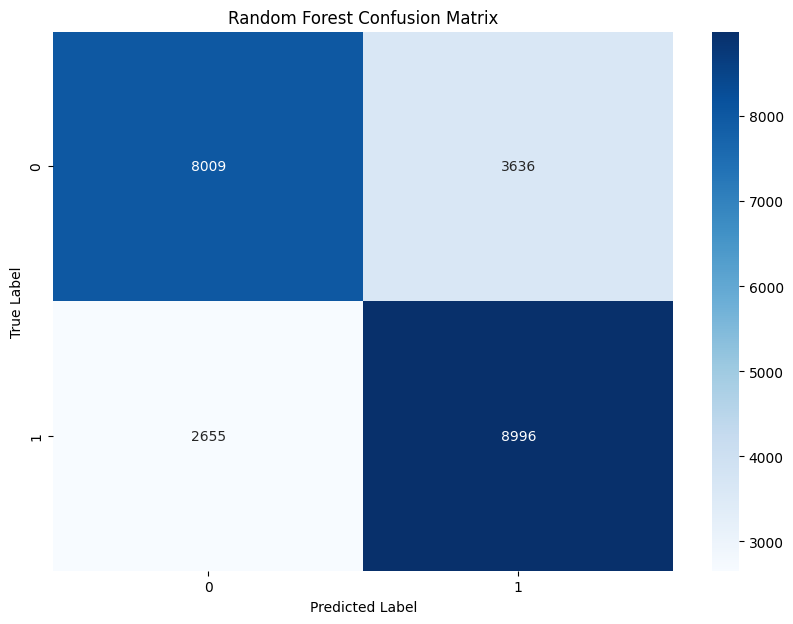

LR Test RMSE = 0.52
Logistic Regression Test AUC = 0.70


In [28]:
# Define the Random Forest model
rf_model = RandomForestClassifier(labelCol="class", featuresCol="features")

# Define the pipeline
rf_pipeline = Pipeline(stages=[rf_model])

# Train the model using the training data
rf_trained_model = rf_pipeline.fit(train_df)

# Make predictions on the testing data
rf_predictions = rf_trained_model.transform(test_df)

# Calculate accuracy
rf_evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
rf_accuracy = rf_evaluator.evaluate(rf_predictions)
print(f"Random Forest Test Accuracy = {rf_accuracy:.2f}")

# Calculate other metrics
rf_predictionAndLabels = rf_predictions.select("prediction", "class").rdd.map(lambda row: (row[0], row[1]))
rf_metrics = MulticlassMetrics(rf_predictionAndLabels)

rf_labels = rf_predictions.select("class").distinct().collect()
rf_labels = [row['class'] for row in rf_labels]

for label in rf_labels:
    precision = rf_metrics.precision(label)
    recall = rf_metrics.recall(label)
    f1Score = rf_metrics.fMeasure(label)
    print(f"Class {label}:")
    print(f"  Precision = {precision:.2f}")
    print(f"  Recall = {recall:.2f}")
    print(f"  F1 Score = {f1Score:.2f}")

# Create confusion matrix
rf_confusion_matrix = rf_metrics.confusionMatrix().toArray()
rf_confusion_matrix = rf_confusion_matrix.astype(int)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(rf_confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Calculate RMSE
regression_evaluator = RegressionEvaluator(labelCol="class", predictionCol="prediction", metricName="rmse")
rmse = regression_evaluator.evaluate(predictions)
print(f"LR Test RMSE = {rmse:.2f}")

# Calculate AUC
binary_evaluator = BinaryClassificationEvaluator(labelCol="class", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = binary_evaluator.evaluate(predictions)
print(f"Logistic Regression Test AUC = {auc:.2f}")

Gradient-Boosted Trees Test Accuracy = 0.74
Class 0.0:
  Precision = 0.74
  Recall = 0.75
  F1 Score = 0.74
Class 1.0:
  Precision = 0.74
  Recall = 0.73
  F1 Score = 0.74


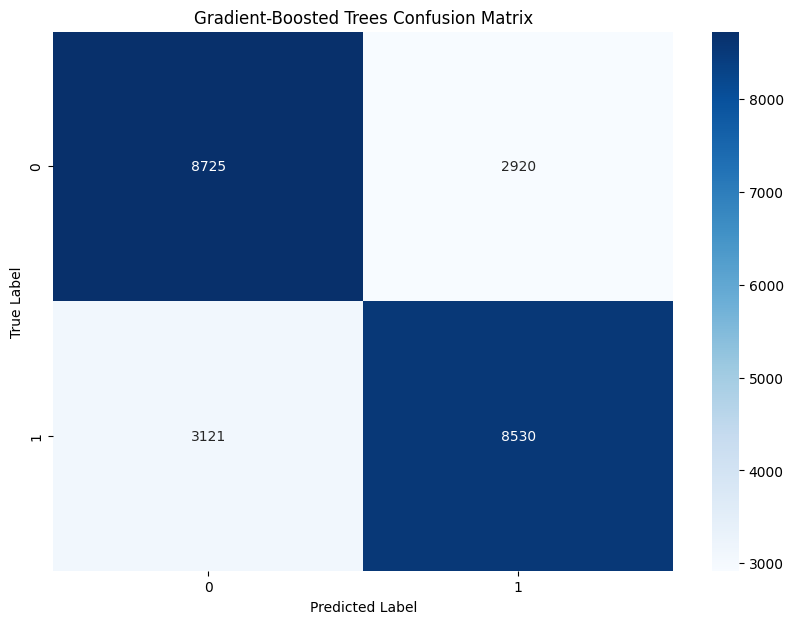

LR Test RMSE = 0.52
Logistic Regression Test AUC = 0.70


In [29]:
# Define the Gradient-Boosted Trees model
gbt_model = GBTClassifier(labelCol="class", featuresCol="features")

# Define the pipeline
gbt_pipeline = Pipeline(stages=[gbt_model])

# Train the model using the training data
gbt_trained_model = gbt_pipeline.fit(train_df)

# Make predictions on the testing data
gbt_predictions = gbt_trained_model.transform(test_df)

# Calculate accuracy
gbt_evaluator = MulticlassClassificationEvaluator(labelCol="class", predictionCol="prediction", metricName="accuracy")
gbt_accuracy = gbt_evaluator.evaluate(gbt_predictions)
print(f"Gradient-Boosted Trees Test Accuracy = {gbt_accuracy:.2f}")

# Calculate other metrics
gbt_predictionAndLabels = gbt_predictions.select("prediction", "class").rdd.map(lambda row: (row[0], row[1]))
gbt_metrics = MulticlassMetrics(gbt_predictionAndLabels)

gbt_labels = gbt_predictions.select("class").distinct().collect()
gbt_labels = [row['class'] for row in gbt_labels]

for label in gbt_labels:
    precision = gbt_metrics.precision(label)
    recall = gbt_metrics.recall(label)
    f1Score = gbt_metrics.fMeasure(label)
    print(f"Class {label}:")
    print(f"  Precision = {precision:.2f}")
    print(f"  Recall = {recall:.2f}")
    print(f"  F1 Score = {f1Score:.2f}")

# Create confusion matrix
gbt_confusion_matrix = gbt_metrics.confusionMatrix().toArray()
gbt_confusion_matrix = gbt_confusion_matrix.astype(int)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(gbt_confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Gradient-Boosted Trees Confusion Matrix')
plt.show()

# Calculate RMSE
regression_evaluator = RegressionEvaluator(labelCol="class", predictionCol="prediction", metricName="rmse")
rmse = regression_evaluator.evaluate(predictions)
print(f"LR Test RMSE = {rmse:.2f}")

# Calculate AUC
binary_evaluator = BinaryClassificationEvaluator(labelCol="class", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = binary_evaluator.evaluate(predictions)
print(f"Logistic Regression Test AUC = {auc:.2f}")